## Data Pre-processing

In [28]:
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('quora_challenge.csv')

In [29]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' %re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text
    
df_clean = pd.DataFrame(df['question_text'].apply(lambda x: clean_text(x)))

nlp = spacy.load('en')

def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["question_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['question_text']), axis=1)
df_clean['question_lemmatize_clean'] = df_clean['question_lemmatize'].str.replace('-PRON-', '')

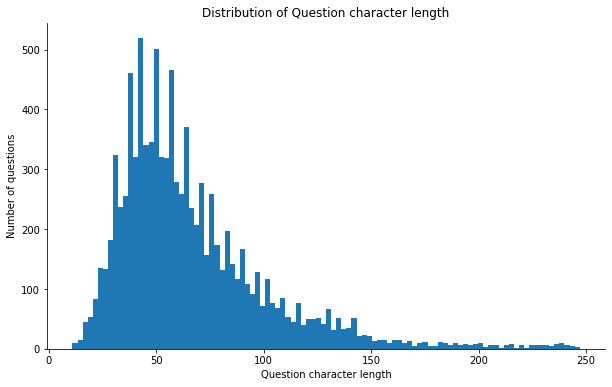

In [30]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.question_text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Question character length')
plt.ylabel('Number of questions')
plt.xlabel('Question character length')
sns.despine();

## EDA

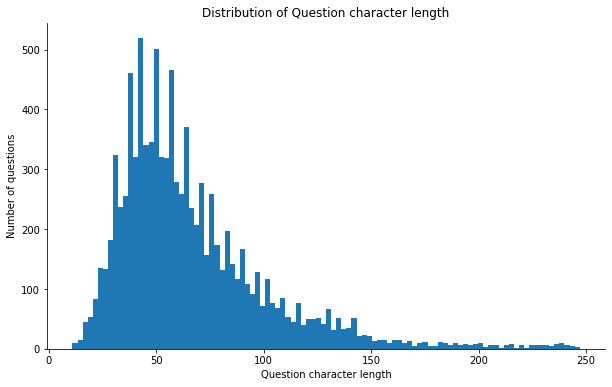

In [31]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.question_text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Question character length')
plt.ylabel('Number of questions')
plt.xlabel('Question character length')
sns.despine();

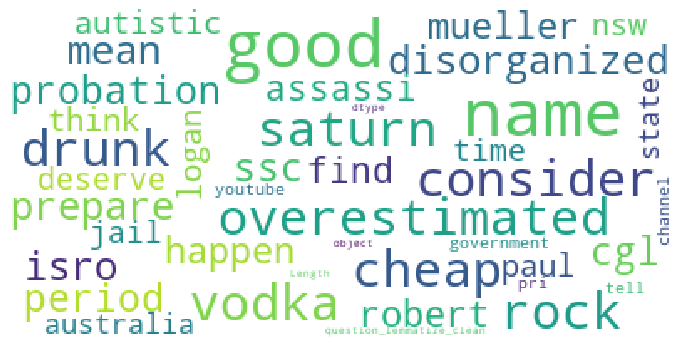

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['question_lemmatize_clean']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [33]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['question_lemmatize_clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [34]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['question_lemmatize_clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [35]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['question_lemmatize_clean'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the question text"))
fig.show()

## Topic Modeling

In [36]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

In [37]:
data_vectorized = vectorizer.fit_transform(df_clean['question_lemmatize_clean'])

In [38]:
lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

In [39]:
pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

In [40]:
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  7.100790
2      -60.884026  -75.591820       2        1  6.990904
19      -2.336119  -53.289074       3        1  6.565229
16     -61.385319  -12.914634       4        1  6.294922
17     -28.737743  126.296997       5        1  5.304353
5        1.066606 -123.552811       6        1  5.222964
6       45.140720   -7.947869       7        1  5.051109
3     -140.795975  -98.530548       8        1  4.887460
9       61.531681  -83.240562       9        1  4.826725
8      -72.563057 -140.396881      10        1  4.719110
11      15.984491   63.578186      11        1  4.707050
13    -160.851624   68.945145      12        1  4.693103
15      85.961830   51.922935      13        1  4.572048
12     -99.020836  109.936348      14        1  4.558390
1     -176.764130   -8.681684      15        1  4.382439
7     -117.189880  -37.420200      16        1  4.371224
18     108.829918  -22.946203      17        1  4.312910
4       47.588097  121.934814      18        1  4.258056
14    -106.467834   30.176889      19        1  4.229534
10     -50.613804   59.328842      20        1  2.951681, topic_info=               Term        Freq       Total Category  logprob  loglift
1241           good  708.000000  708.000000  Default  30.0000  30.0000
3113            use  328.000000  328.000000  Default  29.0000  29.0000
1745           make  312.000000  312.000000  Default  28.0000  28.0000
2129         people  329.000000  329.000000  Default  27.0000  27.0000
3251           work  199.000000  199.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
411          campus   13.090000   13.975070  Topic20  -4.5814   3.4574
620   consideration   12.929420   13.814489  Topic20  -4.5938   3.4566
19           accord   12.708538   13.593607  Topic20  -4.6110   3.4555
589      completely   12.398016   13.283088  Topic20  -4.6358   3.4538
2724          smell   11.550879   12.435948  Topic20  -4.7065   3.4490

[651 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3         6  0.980053            able
13        3  0.953776          accept
18        9  0.975095  accomplishment
19       20  0.956332          accord
20        1  0.972257         account
...     ...       ...             ...
3257      2  0.973710           worth
3260      7  0.994275           write
3263      8  0.967780           wrong
3266      4  0.994640            year
3271      6  0.968114           young

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 20, 17, 18, 6, 7, 4, 10, 9, 12, 14, 16, 13, 2, 8, 19, 5, 15, 11])

In [41]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,people,like,want,job,friend,study,old,really,need,word,canada,government,affect,leave,account,talk,result,dog,large,hair
Topic 1,change,help,human,language,video,english,song,run,view,animal,turn,event,away,difficult,model,programming,speak,thought,manage,seat
Topic 2,make,student,new,start,money,girl,look,movie,class,right,sex,software,watch,value,engineer,chance,age,card,believe,story
Topic 3,learn,day,school,woman,career,man,improve,water,end,choose,degree,skill,wrong,machine,complete,earth,board,hour,break,product
Topic 4,work,type,eat,problem,field,face,home,tip,law,facebook,treat,medical,teacher,likely,solve,email,hyderabad,measure,strong,opportunity
Topic 5,different,live,online,place,market,history,china,able,order,grow,american,test,period,plan,code,current,black,stock,charge,education
Topic 6,use,life,write,like,real,reason,actually,function,research,develop,post,paper,favorite,music,professional,interesting,include,happy,brain,engine
Topic 7,cause,engineering,pay,app,course,play,rank,america,bank,president,useful,explain,theory,fast,meaning,set,laptop,cricket,sign,cut
Topic 8,person,bad,ask,science,child,guy,try,parent,kind,benefit,stay,popular,political,team,graduate,marry,rate,partner,subject,let
Topic 9,mean,difference,long,business,example,lose,people,food,trump,major,project,read,mobile,area,care,add,single,expect,hear,option


In [42]:
Topics_theme = ['American/Car/Marriage/Story/Life in general', 'Education/Business/Money', 'American Medicare/Trump', 'State/Social/Rights', 
                'Build new life', 'Highly educated Indian engineers in America', 'Tips on improving work day efficiency', 'College/Service/Power', 
                'Company/Human/Invest', 'Bank account/Charge', 'Book/Indian/App/Technology', 'War/Future/Family/USA/Race/Political', 
                'Government/President/Society', 'Relationship/China/Parent/Japan', 'Application/Energy/Machine/Economic/Art/Europe', 'Earth/Marketing/Culture', 
               'Air/Rate/Sleep/Blood/Email', 'Student/Internet/Computer/Science/Research', 'University/Engineering/Language/Software', 
                'Job/Learn/Skill improvement']
df_topic_keywords['topic_theme'] = Topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,American/Car/Marriage/Story/Life in general,Education/Business/Money,American Medicare/Trump,State/Social/Rights,Build new life,Highly educated Indian engineers in America,Tips on improving work day efficiency,College/Service/Power,Company/Human/Invest,Bank account/Charge,Book/Indian/App/Technology,War/Future/Family/USA/Race/Political,Government/President/Society,Relationship/China/Parent/Japan,Application/Energy/Machine/Economic/Art/Europe,Earth/Marketing/Culture,Air/Rate/Sleep/Blood/Email,Student/Internet/Computer/Science/Research,University/Engineering/Language/Software,Job/Learn/Skill improvement
Word 0,people,change,make,learn,work,different,use,cause,person,mean,score,happen,country,know,feel,love,year,india,think,good
Word 1,like,help,student,day,type,live,life,engineering,bad,difference,week,possible,state,time,quora,war,world,way,come,book
Word 2,want,human,new,school,eat,online,write,pay,ask,long,pass,car,university,thing,question,month,college,company,stop,computer
Word 3,job,language,start,woman,problem,place,like,app,science,business,training,form,consider,say,answer,number,high,just,tell,game
Word 4,friend,video,money,career,field,market,real,course,child,example,produce,date,power,exam,relationship,point,indian,create,phone,free
Word 5,study,english,girl,man,face,history,reason,play,guy,lose,follow,easy,social,prepare,group,apply,big,buy,developer,google
Word 6,old,song,look,improve,home,china,actually,rank,try,people,medium,future,build,mark,hate,important,experience,family,effect,allow
Word 7,really,run,movie,water,tip,able,function,america,parent,food,device,exist,body,increase,provide,process,term,force,deal,travel
Word 8,need,view,class,end,law,order,research,bank,kind,trump,eye,share,hard,act,die,require,service,application,white,today
Word 9,word,animal,right,choose,facebook,grow,develop,president,benefit,major,method,jee,cost,space,personal,case,like,usa,android,idea


In [50]:
Topics_theme.__len__()

20

In [43]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(df_clean))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df_clean, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['question_text', 'dominant_topic']]

def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'American/Car/Marriage/Story/Life in general'
    if row['dominant_topic'] == 1 :
        return 'Education/Business/Money'
    if row['dominant_topic'] == 2 :
        return 'American Medicare/Trump'
    if row['dominant_topic'] == 3:
        return 'State/Social/Rights'
    if row['dominant_topic']  == 4:
        return 'Build new life'
    if row['dominant_topic'] == 5:
        return 'Highly educated Indian engineers in America'
    if row['dominant_topic'] == 6:
        return 'Tips on improving work day efficiency'
    if row['dominant_topic'] == 7:
        return 'College/Service/Power'
    if row['dominant_topic'] == 8:
        return 'Company/Human/Invest'
    if row['dominant_topic'] == 9:
        return 'Bank account/Charge'
    if row['dominant_topic'] == 10:
        return 'Book/Indian/App/Technology'
    if row['dominant_topic'] == 11:
        return 'War/Future/Family/USA/Race/Political'
    if row['dominant_topic'] == 12:
        return 'Government/President/Society'
    if row['dominant_topic'] == 13:
        return 'Relationship/China/Parent/Japan'
    if row['dominant_topic'] == 14:
        return 'Application/Energy/Machine/Economic/Art/Europe'
    if row['dominant_topic'] == 15:
        return 'Earth/Marketing/Culture'
    if row['dominant_topic'] == 16:
        return 'Air/Rate/Sleep/Blood/Email'
    if row['dominant_topic'] == 17:
        return 'Student/Internet/Computer/Science/Research'
    if row['dominant_topic'] == 18:
        return 'University/Engineering/Language/Software'
    if row['dominant_topic'] == 19:
        return 'Job/Learn/Skill improvement'
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)
df_topic_theme.head(15)

/Users/ratebkahhaleh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,question_text,dominant_topic,dominant_topic_theme
0,why is saturn v considered an overestimated ro...,0,American/Car/Marriage/Story/Life in general
1,why is cheap vodka so good,15,Earth/Marketing/Culture
2,what does drunk and disorganized mean,9,Bank account/Charge
3,how can i prepare for isro,13,Relationship/China/Parent/Japan
4,what is the probation period after ssc cgl,5,Highly educated Indian engineers in America
5,what cpu is better for flight simulation or,18,University/Engineering/Language/Software
6,which one is the safest hoverboard to buy in,17,Student/Internet/Computer/Science/Research
7,can we change the human model as far as ingest...,1,Education/Business/Money
8,why do some christians make some of those nonc...,2,American Medicare/Trump
9,who have been the worst cast actors for movies...,8,Company/Human/Invest


In [45]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out
    
    #nlp = spacy.load('en', disable=['parser', 'ner'])

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["What are the most important lessons you have learned in your life and when did you learn them?"]
topic, prob_scores = predict_topic(text = mytext)
print(topic, prob_scores)

['learn', 'day', 'school', 'woman', 'career', 'man', 'improve', 'water', 'end', 'choose', 'degree', 'skill', 'wrong', 'machine', 'complete', 'earth', 'board', 'hour', 'break', 'product'] [[0.00833333 0.00833333 0.00833333 0.34166667 0.175      0.00833333
  0.175      0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
  0.00833333 0.00833333 0.00833333 0.175      0.00833333 0.00833333
  0.00833333 0.00833333]]


In [49]:
n_features = 4000
n_components = 20
n_top_words = 20

# ignore terms that have a document frequency strictly higher than 95%, 
# ignore terms that have a document frequency strictly lower than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_clean['question_lemmatize_clean'].values.astype(str))

# alpha=0 means no regularization, l1_ratio=.5, the penalty is a combination of L1 and L2
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
nmf_output = nmf.fit_transform(tfidf)

def show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

Topics_theme = ['Word start from ph', 'People/Friend/Relationship', 'Life/Experience/Love/Purpose', 'Money/Internet/Business', 
                'Weekend/Parent/Child', 'Leisure time', 'Language/technique/software', 'Relationship/Girl/Boy', 
                'Business relate to India, China or Pakistan', 'Friend/Love/Relationship', 'Difference and similarity/Language/Engineering', 
                'Culture, travel and visa requirements in several countries', 'Tips on working as software engineering', 'Book/Movie/Class/History/Physics/Chemistry/Science', 
                'Software engineer job opportunitis in Canada', 'Love/Life/Relationship', 'World/War/Language/History', 'Day/Hour/Week/Month/Sex/Place', 'School/Student/College/University', 
                'Question/Answer/Quora/Interview']
df_topic_keywords['topic_theme'] = Topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,Word start from ph,People/Friend/Relationship,Life/Experience/Love/Purpose,Money/Internet/Business,Weekend/Parent/Child,Leisure time,Language/technique/software,Relationship/Girl/Boy,"Business relate to India, China or Pakistan",Friend/Love/Relationship,Difference and similarity/Language/Engineering,"Culture, travel and visa requirements in several countries",Tips on working as software engineering,Book/Movie/Class/History/Physics/Chemistry/Science,Software engineer job opportunitis in Canada,Love/Life/Relationship,World/War/Language/History,Day/Hour/Week/Month/Sex/Place,School/Student/College/University,Question/Answer/Quora/Interview
Word 0,good,people,use,make,like,know,india,life,difference,work,mean,year,way,quora,think,thing,happen,job,study,change
Word 1,book,say,device,money,feel,love,china,real,human,start,word,old,improve,question,stop,learn,robert,pay,university,time
Word 2,place,live,instead,movie,girl,want,course,person,state,useful,dream,experience,easy,answer,gst,bad,eat,government,exam,career
Word 3,app,love,word,career,look,need,future,experience,experience,tip,say,child,weight,ask,movie,weird,sleep,interview,science,novel
Word 4,college,believe,tool,sense,taste,friend,pakistan,dream,professional,canada,friend,student,fast,delete,chinese,hate,world,experience,abroad,state
Word 5,company,young,book,bread,live,man,cost,far,plane,company,girl,live,remove,come,suicide,really,event,complete,math,society
Word 6,bad,dog,sentence,student,friend,learn,economy,affect,cut,home,song,female,stop,tell,bad,unusual,chlorine,available,material,character
Word 7,website,age,material,software,guy,sex,relation,try,culture,business,stare,want,prevent,write,politic,school,relationship,canada,focus,world
Word 8,learn,money,machine,choice,woman,long,fresher,happy,plant,place,family,ago,effective,comment,past,important,pass,need,engineering,process
Word 9,university,look,time,body,new,famous,buy,human,muslims,engineer,baby,relationship,money,user,china,business,sign,opportunity,canada,family


In [48]:
from sklearn.decomposition import NMF